In [1]:
import numpy as np
import pandas as pd
#1
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
#2
from skimage import io
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle
from sklearn.mixture import GaussianMixture
#3
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
import string
from wordcloud import WordCloud
#4
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation
#
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/oranges-vs-grapefruit/citrus.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv
/kaggle/input/kotyata/tatsumiyamai_1638019067506390.jpg


**TASK 1**

In [2]:
data = pd.read_csv('/kaggle/input/oranges-vs-grapefruit/citrus.csv')
data.head(10)

,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9
5,orange,4.59,95.86,142,100,2
6,orange,4.64,97.94,156,85,2
7,orange,4.65,98.50,142,74,2
8,orange,4.68,100.20,159,90,16
9,orange,4.69,100.31,161,76,6


In [3]:
X = data.drop(['name'], axis = 1)
y = data['name']


scaler = StandardScaler()
X_std = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

new_X = pd.DataFrame(X_pca)
new_X.head()

,0,1
0,4.924872,0.519866
1,4.219046,0.075198
2,3.837757,-0.785712
3,3.890732,-0.117696
4,3.359583,-0.249468


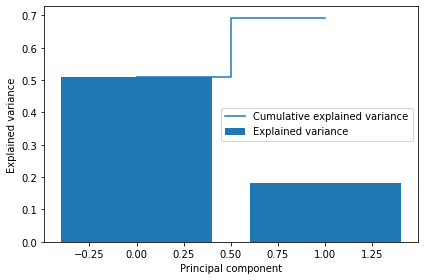

In [4]:
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, align='center', label='Explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance')
plt.xlabel('Principal component')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

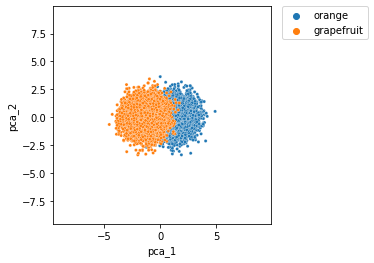

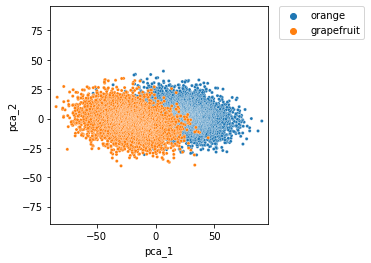

In [5]:
pca2=PCA(n_components=2)
pca_result2 = pca2.fit_transform(X) #without scaler

pca_result_df = pd.DataFrame({'pca_1': X_pca[:,0], 'pca_2': X_pca[:,1], 'label': y})
pca_result_df2 = pd.DataFrame({'pca_1': pca_result2[:,0], 'pca_2': pca_result2[:,1], 'label': y})

fig, ax = plt.subplots(1)
sns.scatterplot(x='pca_1', y='pca_2', hue='label', data=pca_result_df, ax=ax,s=10)
lim = (X_pca.min()-5, X_pca.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

fig2, ax2 = plt.subplots(1)
sns.scatterplot(x='pca_1', y='pca_2', hue='label', data=pca_result_df2, ax=ax2,s=10)
lim = (pca_result2.min()-5, pca_result2.max()+5)
ax2.set_xlim(lim)
ax2.set_ylim(lim)
ax2.set_aspect('equal')
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

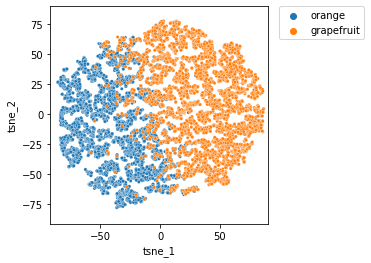

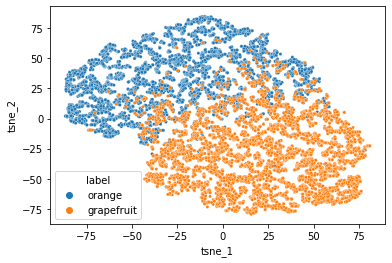

In [6]:
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(X_std)

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})

fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=10)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

tsne2 = TSNE(n_components=2)
tsne_result2 = tsne.fit_transform(X)

tsne_result_df2 = pd.DataFrame({'tsne_1': tsne_result2[:,0], 'tsne_2': tsne_result2[:,1], 'label': y})

fig2, ax2 = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df2, ax=ax2,s=10)
lim = (tsne_result2.min()-5, tsne_result2.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

 **TASK 2.1**

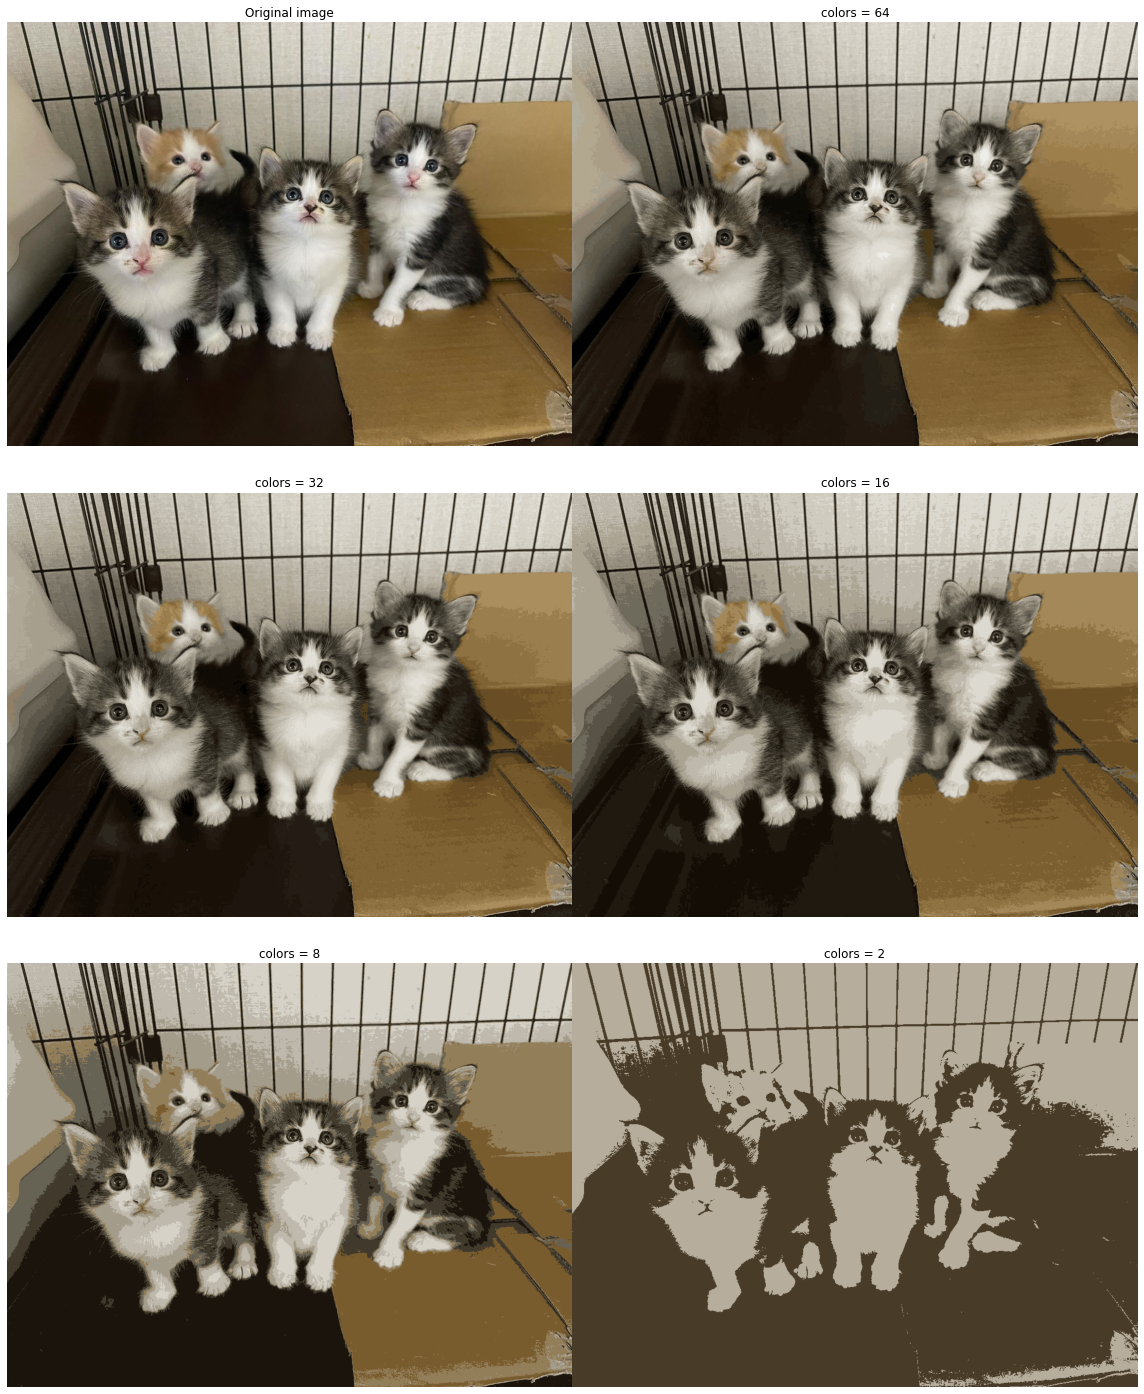

In [7]:
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)

def quantize_image(img, n_colors):
    reshaped_img = np.reshape(img, (img.shape[0] * img.shape[1], img.shape[2]))
    img_sample = shuffle(reshaped_img, random_state=0, n_samples=1000)
    kmeans2 = KMeans(n_clusters=n_colors, random_state=0).fit(img_sample)
    labels = kmeans2.predict(reshaped_img)
    result = recreate_image(kmeans2.cluster_centers_, labels, img.shape[0], img.shape[1])
    return result

kotyata = io.imread("../input/kotyata/tatsumiyamai_1638019067506390.jpg").astype(np.float64)/255


fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16,20))
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=1)

ax[0,0].imshow(kotyata)
ax[0,1].imshow(quantize_image(kotyata, 64))
ax[1,0].imshow(quantize_image(kotyata, 32))
ax[1,1].imshow(quantize_image(kotyata, 16))
ax[2,0].imshow(quantize_image(kotyata, 8))
ax[2,1].imshow(quantize_image(kotyata, 2))

ax[0,0].set_title("Original image")
ax[0,1].set_title("colors = 64")
ax[1,0].set_title("colors = 32")
ax[1,1].set_title("colors = 16")
ax[2,0].set_title("colors = 8")
ax[2,1].set_title("colors = 2")

ax[0,0].axis("off")
ax[0,1].axis("off")
ax[1,0].axis("off")
ax[1,1].axis("off")
ax[2,0].axis("off")
ax[2,1].axis("off")
fig.tight_layout(h_pad = 0, w_pad = 0)
plt.show()

**TASK 2.2**

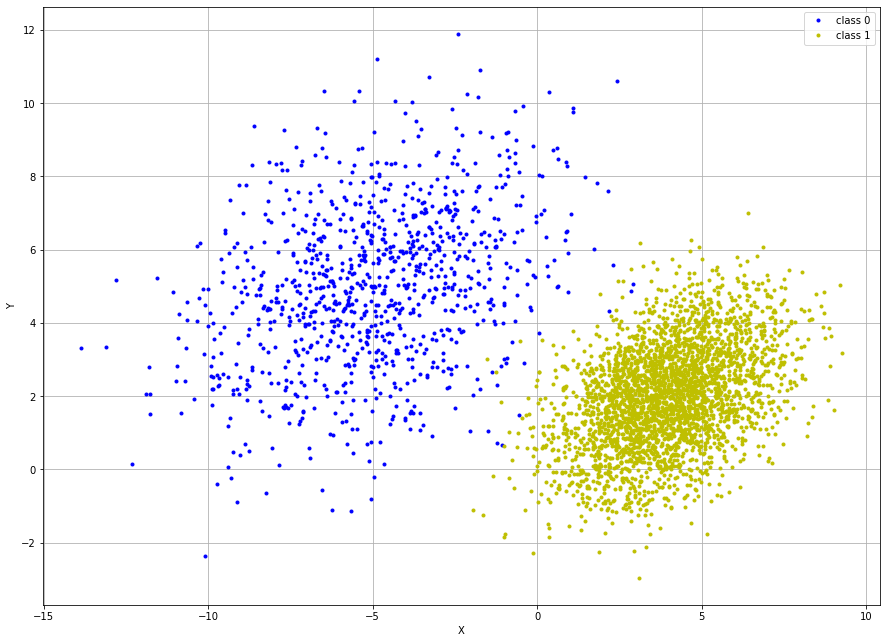

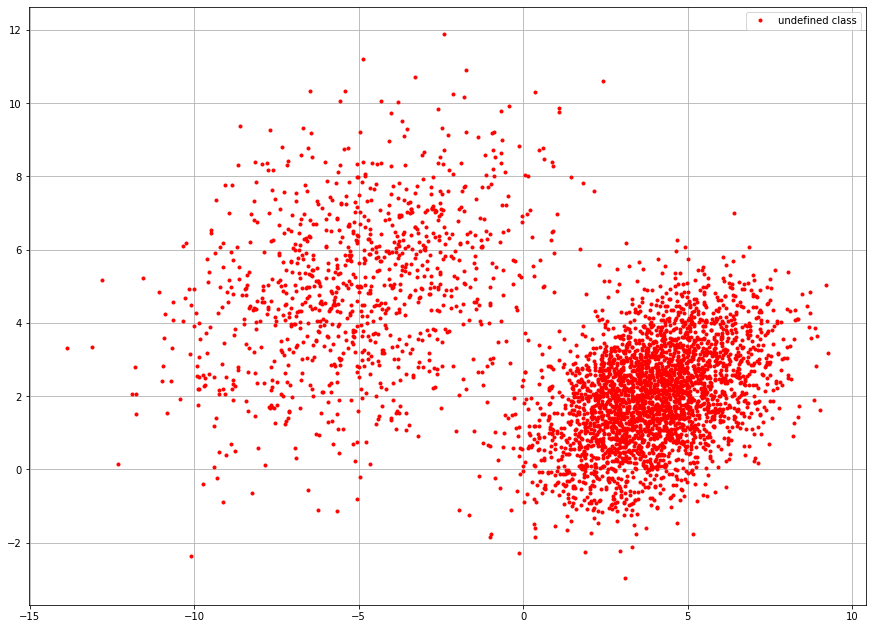

In [8]:
number_of_points = 1000
mean1 = [-5,5]
cov1 = [[7, 2],
        [2, 5]]
mean2 = [4,2]
cov2 = [[3, 1], 
        [1, 2]]
x_1 = np.random.multivariate_normal(mean1, cov1, (number_of_points))
x_2 = np.random.multivariate_normal(mean2, cov2, (number_of_points*3))
plt.figure(figsize=(15,11))
plt.plot(x_1[...,0], x_1[...,1], 'b.', label = "class 0")
plt.plot(x_2[...,0], x_2[...,1], 'y.', label = "class 1")
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.show()

x = np.concatenate([x_1,x_2])
plt.figure(figsize=(15,11))
plt.plot(x[...,0], x[...,1], 'r.', label = "undefined class")
plt.grid()
plt.legend()
plt.show()

In [9]:
gm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
gm.fit(x)
print("Means: ")
print(gm.means_)
print("True means: ")
print(np.stack([mean2, mean1]))
print("Difference of means: ")
print(gm.means_ - np.stack([mean2, mean1]))
print("____________________________________________")
print("Covariation matrixes: ")
print(gm.covariances_)
print("True covariation matrixes: ")
print(np.stack([cov2, cov1]))
print("Difference of covariation matrixes: ")
print(gm.covariances_ - np.stack([cov2, cov1]))
print("Weights:")
print(gm.weights_)

Means: 
[[ 3.94753105  1.99497765]
 [-4.98351065  4.99926037]]
True means: 
[[ 4  2]
 [-5  5]]
Difference of means: 
[[-0.05246895 -0.00502235]
 [ 0.01648935 -0.00073963]]
____________________________________________
Covariation matrixes: 
[[[2.97033645 1.01600865]
  [1.01600865 1.98563847]]

 [[7.49782441 2.01319907]
  [2.01319907 4.77787751]]]
True covariation matrixes: 
[[[3 1]
  [1 2]]

 [[7 2]
  [2 5]]]
Difference of covariation matrixes: 
[[[-0.02966355  0.01600865]
  [ 0.01600865 -0.01436153]]

 [[ 0.49782441  0.01319907]
  [ 0.01319907 -0.22212249]]]
Weights:
[0.7501467 0.2498533]


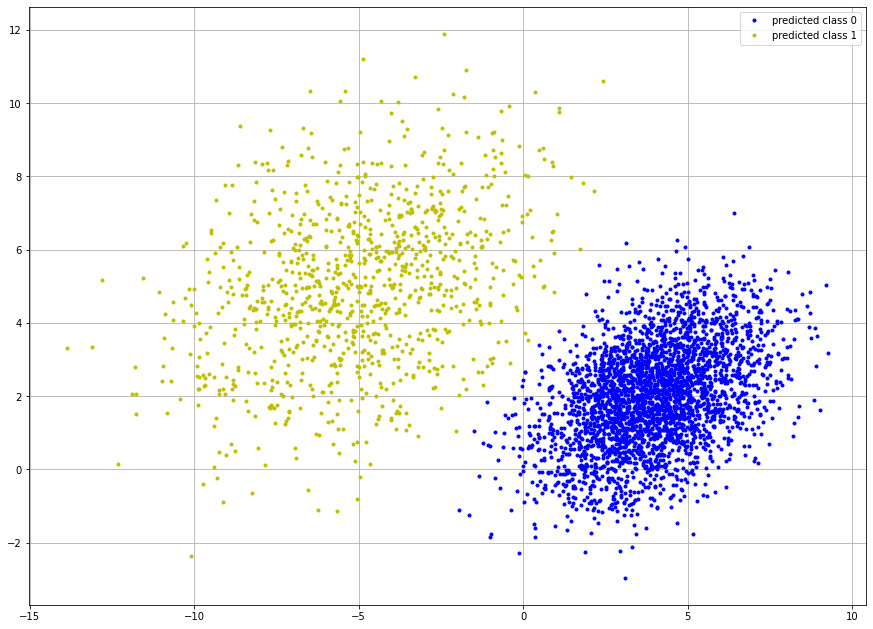

In [10]:
y_predict = gm.predict(x)
x_pred0 = x[y_predict == 0]
x_pred1 = x[y_predict == 1]
plt.figure(figsize=(15,11))
plt.plot(x_pred0[...,0], x_pred0[...,1], 'b.', label = "predicted class 0")
plt.plot(x_pred1[...,0], x_pred1[...,1], 'y.', label = "predicted class 1")
plt.grid()
plt.legend()
plt.show()

**TASK 3**

In [11]:
text_data = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='latin-1')

# text_data_x = text_data['OriginalTweet']
# text_data_y = text_data['Sentiment']
classes = text_data.Sentiment.unique()
# for i in range(len(classes)):
#     text_data_y.replace(classes[i], i)
# text_data_x.head()
# print(text_data.loc[0, 'OriginalTweet'])
text_data = text_data.drop(columns=['UserName', 'ScreenName', 'Location', 'TweetAt'], axis = 1)
text_data.head()
                

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub("@\S+", " ", text)
    text = re.sub("https*\S+", " ", text)
    text = re.sub("#\S+", " ", text)
    text = re.sub("\d", " ", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\s{2,}',' ', text)
    stop_words = stopwords.words("english")
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    return text
for i in range(text_data['OriginalTweet'].shape[0]):
    text_data.loc[i, 'OriginalTweet'] = clean_text(text_data.loc[i, 'OriginalTweet'])

# text_data['OriginalTweet'] = text_data['OriginalTweet'].apply(lambda x: word_tokenize(x))
text_data['OriginalTweet'].head(10)

0                                                     
1    advice talk neighbours family exchange phone n...
2    coronavirus australia woolworths give elderly ...
3    food stock one empty please panic enough food ...
4    ready go supermarket outbreak paranoid food st...
5    news regionâs first confirmed covid case came...
6    cashier grocery store sharing insights prove c...
7                  supermarket today buy toilet paper 
8    due covid retail store classroom atlanta open ...
9    corona prevention stop buy things cash use onl...
Name: OriginalTweet, dtype: object

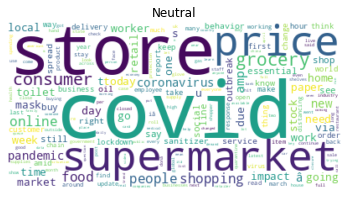

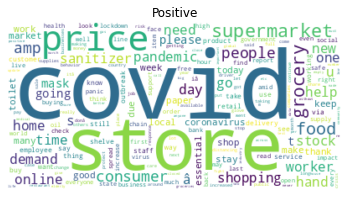

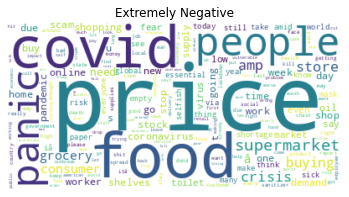

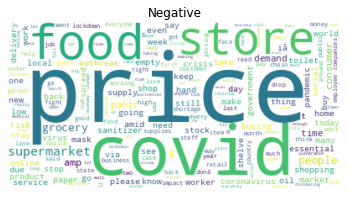

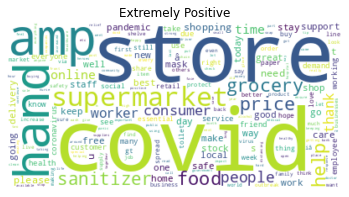

In [13]:
def visualize_class_words(mass, class_label):
    big_row = ' '
    #text_data_from_class = text_data[text_data.Sentiment == classes[0]]
    for row in mass[mass.Sentiment == class_label].OriginalTweet:
        big_row+=(str(row))+' '
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(big_row)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.title(class_label)
    plt.axis("off")
    plt.show()

for i in classes:
    visualize_class_words(text_data, i)

In [14]:
train_covid_data = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='latin-1')
test_covid_data = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding='latin-1')

train_covid_data = train_covid_data.drop(columns=['UserName', 'ScreenName', 'Location', 'TweetAt'], axis = 1)
test_covid_data = test_covid_data.drop(columns=['UserName', 'ScreenName', 'Location', 'TweetAt'], axis = 1)

for i in range(train_covid_data['OriginalTweet'].shape[0]):
    train_covid_data.loc[i, 'OriginalTweet'] = clean_text(train_covid_data.loc[i, 'OriginalTweet'])
# train_covid_data['OriginalTweet'] = train_covid_data['OriginalTweet'].apply(lambda x: word_tokenize(x))
for i in range(test_covid_data['OriginalTweet'].shape[0]):
    test_covid_data.loc[i, 'OriginalTweet'] = clean_text(test_covid_data.loc[i, 'OriginalTweet'])
# test_covid_data['OriginalTweet'] = test_covid_data['OriginalTweet'].apply(lambda x: word_tokenize(x))
# n_features = 1000 
# count_vectorizer = CountVectorizer(max_df=0.95, min_df=0.05,
#                                 max_features=n_features,
#                                    ngram_range=(1, 2),
#                                 stop_words='english')

# train_count_vectorizer = count_vectorizer.fit_transform(train_covid_data.OriginalTweet)
# test_count_vectorizer = count_vectorizer.transform(test_covid_data.OriginalTweet)

# clf = LogisticRegression(random_state=0).fit(train_count_vectorizer, train_covid_data.Sentiment)
# predicted = clf.predict(test_count_vectorizer)

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.05, decode_error='ignore', encoding=None)

tfidf_train = tfidf_vectorizer.fit_transform(train_covid_data.OriginalTweet)
tfidf_test =  tfidf_vectorizer.transform(test_covid_data.OriginalTweet)

clf = LogisticRegression().fit(tfidf_train, train_covid_data.Sentiment)

predicted = clf.predict(tfidf_test)
print(classification_report(test_covid_data.Sentiment, predicted))


                    precision    recall  f1-score   support

Extremely Negative       0.40      0.25      0.31       592
Extremely Positive       0.44      0.03      0.05       599
          Negative       0.36      0.23      0.28      1041
           Neutral       0.35      0.27      0.31       619
          Positive       0.28      0.66      0.39       947

          accuracy                           0.32      3798
         macro avg       0.36      0.29      0.27      3798
      weighted avg       0.36      0.32      0.28      3798



In [15]:
train_covid_data = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='latin-1')
test_covid_data = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding='latin-1')

train_covid_data = train_covid_data.drop(columns=['UserName', 'ScreenName', 'Location', 'TweetAt'], axis = 1)
test_covid_data = test_covid_data.drop(columns=['UserName', 'ScreenName', 'Location', 'TweetAt'], axis = 1)

positive_data_train = train_covid_data[train_covid_data.Sentiment == 'Extremely Positive']
negative_data_train = train_covid_data[train_covid_data.Sentiment == 'Extremely Negative']
extreme_data_train = pd.concat([positive_data_train, negative_data_train])

positive_data_test = test_covid_data[test_covid_data.Sentiment == 'Extremely Positive']
negative_data_test = test_covid_data[test_covid_data.Sentiment == 'Extremely Negative']
extreme_data_test = pd.concat([positive_data_test, negative_data_test])


In [16]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_train = tfidf_vectorizer.fit_transform(extreme_data_train.OriginalTweet)
tfidf_test =  tfidf_vectorizer.transform(extreme_data_test.OriginalTweet)

clf = LogisticRegression().fit(tfidf_train, extreme_data_train.Sentiment)

predicted = clf.predict(tfidf_test)
print(classification_report(extreme_data_test.Sentiment, predicted))

                    precision    recall  f1-score   support

Extremely Negative       0.93      0.92      0.92       592
Extremely Positive       0.92      0.93      0.93       599

          accuracy                           0.92      1191
         macro avg       0.92      0.92      0.92      1191
      weighted avg       0.92      0.92      0.92      1191



In [17]:
tfidf_vectorizer = TfidfVectorizer(max_df=500, min_df=0)

tfidf_train = tfidf_vectorizer.fit_transform(extreme_data_train.OriginalTweet)
tfidf_test =  tfidf_vectorizer.transform(extreme_data_test.OriginalTweet)

clf = LogisticRegression().fit(tfidf_train, extreme_data_train.Sentiment)

predicted = clf.predict(tfidf_test)
print(classification_report(extreme_data_test.Sentiment, predicted))

                    precision    recall  f1-score   support

Extremely Negative       0.89      0.88      0.88       592
Extremely Positive       0.88      0.89      0.88       599

          accuracy                           0.88      1191
         macro avg       0.88      0.88      0.88      1191
      weighted avg       0.88      0.88      0.88      1191



In [18]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_train = tfidf_vectorizer.fit_transform(extreme_data_train.OriginalTweet)
tfidf_test =  tfidf_vectorizer.transform(extreme_data_test.OriginalTweet)

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 500)
rfc.fit(tfidf_train,extreme_data_train.Sentiment)
predictions = rfc.predict(tfidf_test)
print(classification_report(extreme_data_test.Sentiment,predictions))

                    precision    recall  f1-score   support

Extremely Negative       0.90      0.84      0.87       592
Extremely Positive       0.85      0.90      0.88       599

          accuracy                           0.87      1191
         macro avg       0.87      0.87      0.87      1191
      weighted avg       0.87      0.87      0.87      1191



In [19]:
# tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.05) #working variant
tfidf_vectorizer = TfidfVectorizer()

tfidf_train = tfidf_vectorizer.fit_transform(train_covid_data.OriginalTweet)
tfidf_test =  tfidf_vectorizer.transform(test_covid_data.OriginalTweet)

rfc = RandomForestClassifier()
rfc.fit(tfidf_train,train_covid_data.Sentiment)
predictions = rfc.predict(tfidf_test)
print(classification_report(test_covid_data.Sentiment,predictions))


                    precision    recall  f1-score   support

Extremely Negative       0.64      0.24      0.35       592
Extremely Positive       0.68      0.25      0.37       599
          Negative       0.42      0.44      0.43      1041
           Neutral       0.49      0.61      0.55       619
          Positive       0.37      0.58      0.45       947

          accuracy                           0.44      3798
         macro avg       0.52      0.43      0.43      3798
      weighted avg       0.50      0.44      0.43      3798



In [20]:
def plot_top_words(model, feature_names, title, n_top_words=10):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

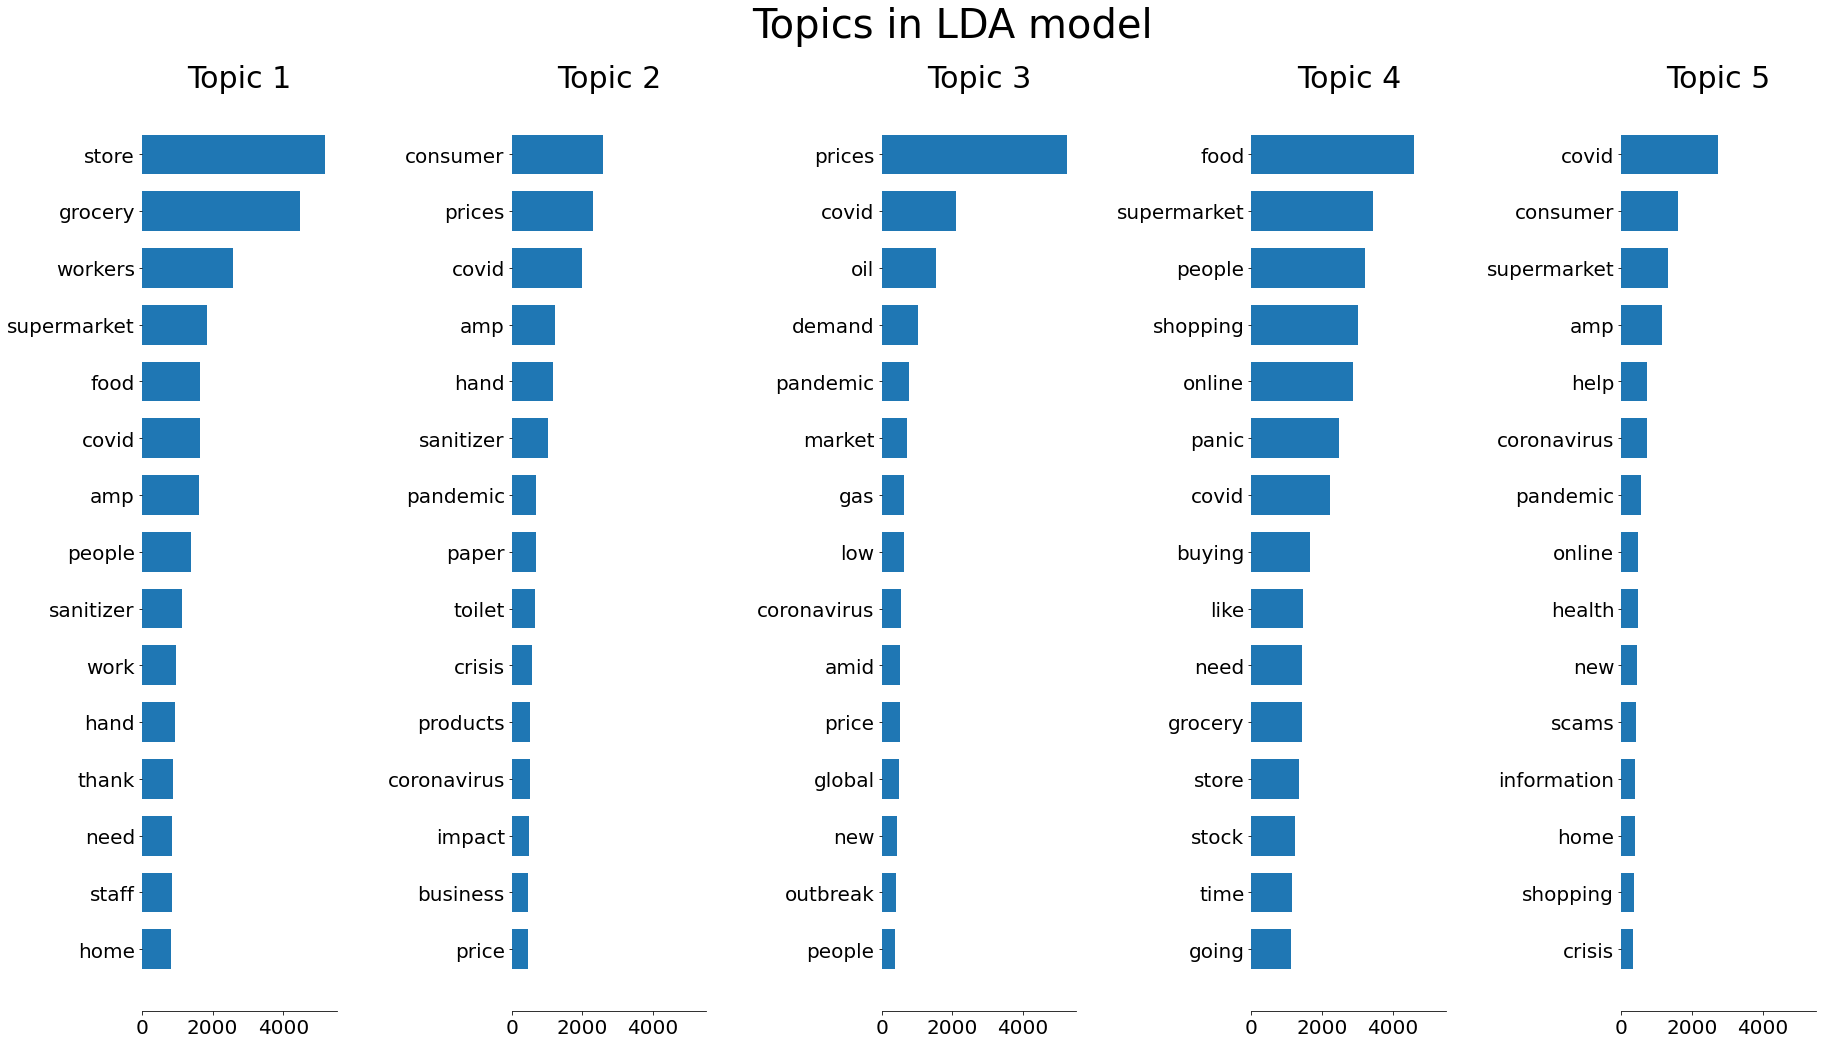

In [21]:
vectorizer = CountVectorizer(stop_words='english')
for i in range(train_covid_data['OriginalTweet'].shape[0]):
    train_covid_data.loc[i, 'OriginalTweet'] = clean_text(train_covid_data.loc[i, 'OriginalTweet'])
data_vectorized = vectorizer.fit_transform(train_covid_data.OriginalTweet)

lda = LatentDirichletAllocation(n_components=5, random_state=0)

lda.fit(data_vectorized)

feature_names = vectorizer.get_feature_names()
plot_top_words(lda, feature_names, 'Topics in LDA model', n_top_words=15)